# LB

In [1]:
import numpy as np
import pandas as pd
import numpy as np
from decimal import Decimal, getcontext
getcontext().prec = 100  # You can increase this if needed


def find_first_mod_1_after_x(x, w):
    remainder = x % w
    if remainder == 0:
        to_add = 1
    else:
        to_add = w - remainder + 1
    return x + to_add


def is_prime(n):
    """Checks if a number is prime."""
    if n < 2:
        return False
    for i in range(2, int(Decimal(n).sqrt()) + 1):
        if n % i == 0:
            return False
    return True

def mobius(n):
    """Calculates the Möbius function value for n with high precision."""
    if n == 1:
        return 1

    # Use Decimal for high-precision sqrt calculation
    n_decimal = Decimal(n)
    sqrt_n = n_decimal.sqrt()

    p = 0  # Count of distinct prime factors


    # Iterate up to ceil(sqrt(n))
    for i in range(2,n):
        if n % i == 0:
            # If i is not prime, skip it
            if not is_prime(i):
                continue

            # If i divides n, check for square factors
            if (n // i) % i == 0:
                return 0  # n has a squared prime factor
            p += 1  # Count the distinct prime factor

    # Check if n itself is prime and greater than sqrt(n)
    if n > 1 and is_prime(n):
        p += 1

    # Return -1 if odd number of prime factors, 1 otherwise
    return -1 if p % 2 else 1

def aperiodic_necklaces(p, sigma):
    """
    Calculates the number of aperiodic necklaces of length p 
    over an alphabet of size sigma using the Möbius function.
    """
    return sum(mobius(p // d) * sigma**d for d in range(1, p + 1) if p % d == 0) // p

def get_lower_bound_improved(sigma, w, k):
    """Calculates the improved lower bound using high precision arithmetic."""
    # Convert inputs to native Python types
    w, k, sigma = int(w), int(k), int(sigma)

    # Use Decimal for high precision calculation of the first term
    first_term = Decimal(1) / (Decimal(sigma) ** Decimal(int(w + k)))

    # Get all divisors of (w + k)
    divisors = [i for i in range(1, w + k + 1) if (w + k) % i == 0]

    
    sum_terms = sum(aperiodic_necklaces(d, sigma) * np.ceil(d / w) for d in divisors)

    return float(first_term * Decimal(sum_terms))


def get_lower_bound_improved_number_windows(sigma, w, k):
    """Calculates the improved lower bound using high precision arithmetic."""
    # Convert inputs to native Python types
    w, k, sigma = int(w), int(k), int(sigma)


    # Get all divisors of (w + k)
    divisors = [i for i in range(1, w + k + 1) if (w + k) % i == 0]

    
    sum_terms = sum(aperiodic_necklaces(d, sigma) * np.ceil(d / w) for d in divisors)

    return sum_terms



def get_best_lower_bound_number_windows(sigma,w,k):
    bound_1 = get_lower_bound_improved_number_windows(sigma,w,k)
    #print(f"Lower bound option 1: {bound_1}")
    k_2 = find_first_mod_1_after_x(k,w)
    k_diff = k_2 - k
    bound_2 = get_lower_bound_improved_number_windows(sigma,w,k_2) / (sigma ** k_diff)
    #print(f"Lower bound option 2 (k adjusted to {k_2}): {bound_2}")
    return (w+1)*max(bound_1, bound_2)/(sigma**(w+k))

# K <= 5

Columns in the CSV: ['k', 'w', 'best_gc', 'average_density_factor', 'ragnars bound', '1/sigma^k']


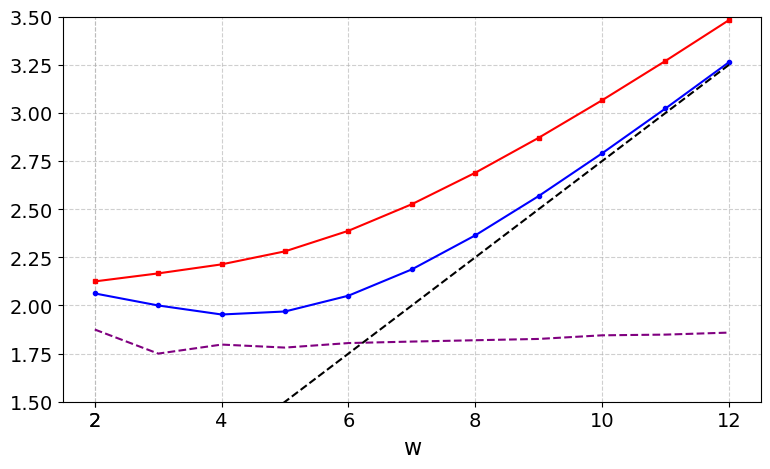

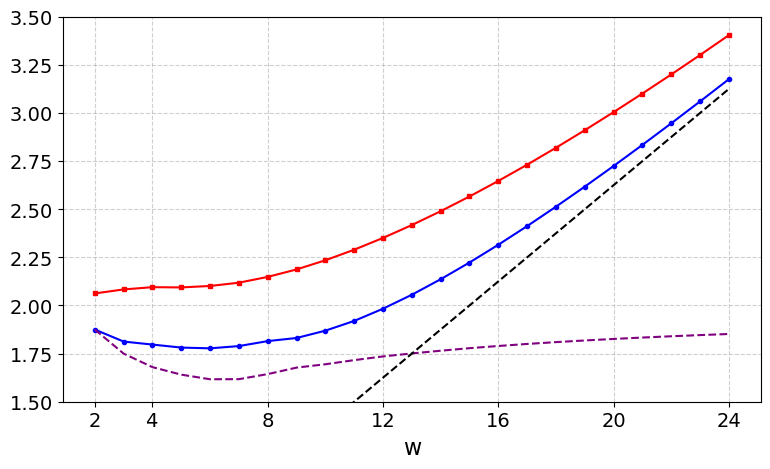

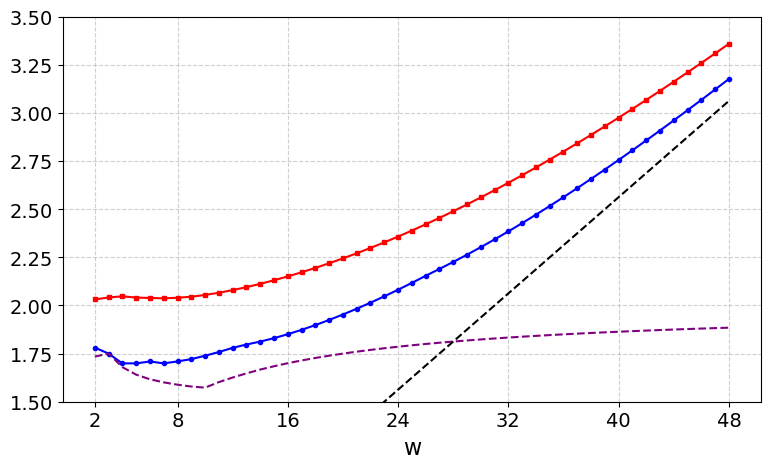

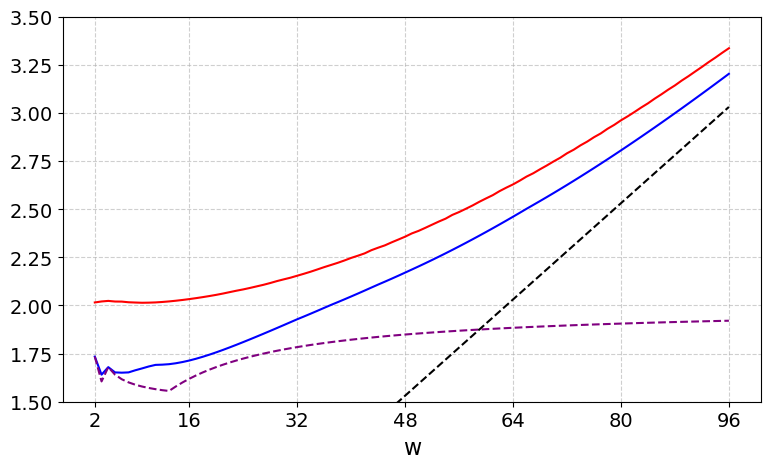

In [2]:
colors = {
    "best_gc": "blue",
    "fallback": "green",
    "gm_upper_bound": "orange",
    "avg_density": "red",
    "ragnar": "purple",
    "sigma_inv": "black",
}

import pandas as pd
import matplotlib.pyplot as plt

# === Load CSV ===
df = pd.read_csv("k_leq_5.csv")
df.columns = [c.strip() for c in df.columns]

print("Columns in the CSV:", df.columns.tolist())

# === Loop over k values ===
for k in range(2, 6):
    sub = df[df["k"] == k].copy()

    # Compute CC safely using Python ints
    sub["CC"] = [(2 ** int(w + k)) / (1 + w) for w in sub["w"]]

    # best_gc normalized (unchanged)
    sub["best_gc_norm"] = sub["best_gc"].astype(float) / sub["CC"]

    # === NEW: Ragnar LB from function ===
    def compute_ragnar(w):
        return get_best_lower_bound_number_windows(2, int(w), int(k))

    sub["ragnars_bound"] = sub["w"].apply(compute_ragnar)

    # === NEW: sigma^{-k} lower bound EXACT = (w+1)/2^k ===
    sub["sigma_inv_val"] = (sub["w"] + 1) * (1 / (2 ** k))

    # === Plot ===
    plt.figure(figsize=(9, 5))

    if k < 5:
        plt.plot(
            sub["w"], sub["best_gc_norm"],
            'o-', markersize=3,
            color=colors["best_gc"],
            label="best_gc / CC"
        )
        plt.plot(
            sub["w"], sub["average_density_factor"],
            's-', markersize=3,
            color=colors["avg_density"],
            label="average_density_factor"
        )
    else:
        plt.plot(
            sub["w"], sub["best_gc_norm"],
            '-', color=colors["best_gc"],
            label="best_gc / CC"
        )
        plt.plot(
            sub["w"], sub["average_density_factor"],
            '-', color=colors["avg_density"],
            label="average_density_factor"
        )

    # === NEW Ragnar LB line (raw, NOT normalized) ===
    plt.plot(
        sub["w"], sub["ragnars_bound"],
        '--', color=colors["ragnar"],
        label="ragnar LB"
    )

    # === NEW sigma^{-k} line ===
    plt.plot(
        sub["w"], sub["sigma_inv_val"],
        '--', color=colors["sigma_inv"],
        label="(w+1)/2^k"
    )

    # === Axis formatting ===
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlabel("w", fontsize=16)
    plt.ylim([1.5, 3.5])

    # === Ticks: 2 then step = 0.5·2^k ===
    step = int(0.5 * (2 ** k))
    w_max = int(sub["w"].max())
    ticks = [2] + list(range(step, w_max + 1, step))
    plt.xticks(ticks, fontsize=14)
    

    plt.yticks(fontsize=14)

    plt.savefig(f"plot_k_{k}.svg", dpi=300)
    plt.show()


# K = 6

Columns: ['w', 'best_gc', 'best_gc_lower_bound', 'gm_upper_bound', 'average_density_factor', 'ragnars bound', '1/sigma^k', 'Unnamed: 7', 'Unnamed: 8']


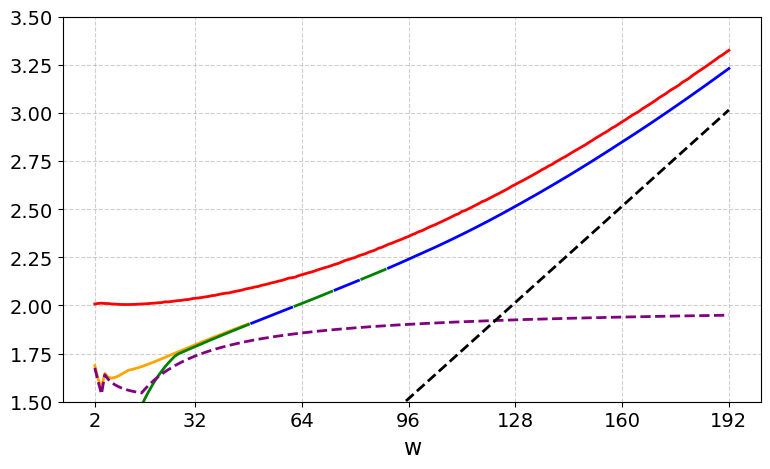

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# === Define color scheme ===
colors = {
    "best_gc": "blue",
    "fallback": "green",
    "gm_upper_bound": "orange",
    "avg_density": "red",
    "ragnar": "purple",
    "sigma_inv": "black",
}

# === Load CSV ===
df = pd.read_csv("k_6.csv")
df.columns = [c.strip() for c in df.columns]

print("Columns:", df.columns.tolist())

# k is fixed
k = 6

# Compute CC = 2^(w+k) / (1+w)
df["CC"] = [(2 ** int(w + k)) / (1 + w) for w in df["w"]]

# Normalize GM upper bound
df["gm_upper_bound_norm"] = df["gm_upper_bound"].astype(float)

# convert best_gc to int for all non-nan values
df["best_gc"] = df["best_gc"].apply(lambda x: int(x) if pd.notna(x) else x)

# Determine where best_gc is real vs fallback
has_real = df["best_gc"].notna() & (df["best_gc"] > 0)
has_fallback = ~has_real

# Create final values (real or fallback)
df["best_gc_final"] = df["best_gc"]
df.loc[has_fallback, "best_gc_final"] = df["best_gc_lower_bound"]
df["best_gc_final_norm"] = df["best_gc_final"].astype(float) / df["CC"]

# Build NaN-separated arrays to break the line
y_real = df["best_gc_final_norm"].copy()
y_real[has_fallback] = float("nan")

y_fallback = df["best_gc_final_norm"].copy()
y_fallback[has_real] = float("nan")

# === CHANGE 1: Ragnar LB computed from function (raw, not normalized) ===
def compute_ragnar(w):
    return get_best_lower_bound_number_windows(2, int(w), int(k))

df["ragnars_bound_raw"] = df["w"].apply(compute_ragnar)

# === CHANGE 2: sigma^{-k} lower bound = (w+1) * (1/2^k) ===
df["sigma_inv_raw"] = (df["w"] + 1) * (1 / (2 ** k))

# === Plot ===
plt.figure(figsize=(9, 5))

# Real best_gc region
plt.plot(
    df["w"], y_real,
    '-', color=colors["best_gc"], linewidth=2,
    label="best_gc / CC"
)



# GM upper bound (only 2→118)
upper = df[df["w"].between(2, 48)]
plt.plot(
    upper["w"], upper["gm_upper_bound_norm"],
    '-', color=colors["gm_upper_bound"], linewidth=2,
    label="GM upper bound / CC"
)

# Fallback region
plt.plot(
    df["w"], y_fallback,
    '-', color=colors["fallback"], linewidth=2,
    label="best_gc_lower_bound (fallback)"
)


# average_density_factor
plt.plot(
    df["w"], df["average_density_factor"],
    '-', color=colors["avg_density"], linewidth=2,
    label="average_density_factor"
)

# === UPDATED Ragnar LB (raw) ===
plt.plot(
    df["w"], df["ragnars_bound_raw"],
    '--', color=colors["ragnar"], linewidth=2,
    label="ragnar LB"
)

# === UPDATED sigma lower bound (raw) ===
plt.plot(
    df["w"], df["sigma_inv_raw"],
    '--', color=colors["sigma_inv"], linewidth=2,
    label="(w+1)/2^k"
)

# === Styling ===
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel("w", fontsize=16)

# === Correct tick rule: 2, 32, 64, 96, ... ===
w_max = int(df["w"].max())
ticks = [2] + list(range(32, w_max + 1, 32))
plt.xticks(ticks, fontsize=14)
plt.ylim([1.5,3.5])

plt.yticks(fontsize=14)

plt.savefig("plot_k_6.svg", dpi=300)
plt.show()


# DNA

Columns: ['w', 'best_gc', 'average_density_factor', 'Unnamed: 3', 'Unnamed: 4']
w=2, best_gc_norm=1.8984375
w=3, best_gc_norm=1.83203125
w=4, best_gc_norm=1.805419921875
w=5, best_gc_norm=1.80322265625
w=6, best_gc_norm=1.813446044921875
w=7, best_gc_norm=1.829010009765625
w=8, best_gc_norm=1.8498573303222656
w=9, best_gc_norm=1.8734431266784668
w=10, best_gc_norm=1.898302674293518
w=11, best_gc_norm=1.9236790537834167
w=12, best_gc_norm=1.9484222196042538
w=13, best_gc_norm=1.973477439954877
w=14, best_gc_norm=1.9989636959508061
w=15, best_gc_norm=2.0249366983771324
w=16, best_gc_norm=2.0514282941439888
w=17, best_gc_norm=2.078511384417652
w=18, best_gc_norm=2.105278882161656
w=19, best_gc_norm=2.1326215696035433
w=20, best_gc_norm=2.160862167496987
w=21, best_gc_norm=2.190159627482956
w=22, best_gc_norm=2.219904202512417
w=23, best_gc_norm=2.24758894009738
w=24, best_gc_norm=2.2765467064914557
w=25, best_gc_norm=2.3065810224504153
w=26, best_gc_norm=2.337789848550204
w=27, best_gc_no

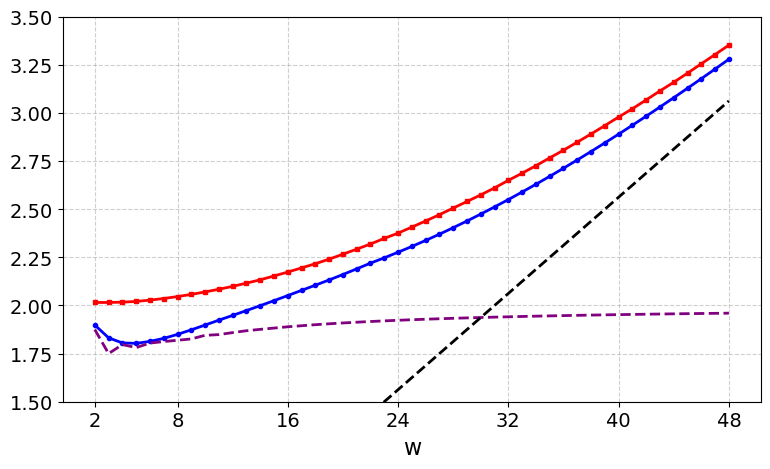

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# === Define color scheme ===
colors = {
    "best_gc": "blue",
    "fallback": "green",      # not used anymore
    "gm_upper_bound": "orange",   # not used anymore
    "avg_density": "red",
    "ragnar": "purple",
    "sigma_inv": "black",
}

# === Load CSV ===
df = pd.read_csv("dna.csv")
df.columns = [c.strip() for c in df.columns]

print("Columns:", df.columns.tolist())

# k is fixed
k = 2

# Compute CC = 4^(w+k) / (1+w)
df["CC"] = [(4 ** int(w + k)) / (1 + w) for w in df["w"]]

# === Use ONLY best_gc — NO fallback ===
df["best_gc_norm"] = df["best_gc"].astype(float) / df["CC"]

# Print values (debug)
for w_val, norm_val in zip(df["w"], df["best_gc_norm"]):
    print(f"w={w_val}, best_gc_norm={norm_val}")

# === Ragnar LB from function (raw) ===
def compute_ragnar(w):
    return get_best_lower_bound_number_windows(2, int(w), int(k))

df["ragnars_bound_raw"] = df["w"].apply(compute_ragnar)

# === sigma^{-k} raw LB = (w+1)*(1/4^k) ===
df["sigma_inv_raw"] = (df["w"] + 1) * (1 / (4 ** k))

# === Plot ===
plt.figure(figsize=(9, 5))

# best_gc_norm (always k<5 style)
plt.plot(
    df["w"], df["best_gc_norm"],
    'o-', markersize=3,
    color=colors["best_gc"], linewidth=2,
    label="best_gc / CC"
)

# average_density_factor (always k<5 style)
plt.plot(
    df["w"], df["average_density_factor"],
    's-', markersize=3,
    color=colors["avg_density"], linewidth=2,
    label="average_density_factor"
)

# Ragnar LB (raw)
plt.plot(
    df["w"], df["ragnars_bound_raw"],
    '--', color=colors["ragnar"], linewidth=2,
    label="ragnar LB"
)

# sigma LB (raw)
plt.plot(
    df["w"], df["sigma_inv_raw"],
    '--', color=colors["sigma_inv"], linewidth=2,
    label="(w+1)/2^k"
)

# === Styling ===
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel("w", fontsize=16)

# Tick rule: 2, 8, 16, 24, ...
w_max = int(df["w"].max())
ticks = [2] + list(range(8, w_max + 1, 8))
plt.xticks(ticks, fontsize=14)

plt.ylim([1.5, 3.5])
plt.yticks(fontsize=14)

plt.savefig("plot_dna_k2.svg", dpi=300)
plt.show()


# runtime for k=6

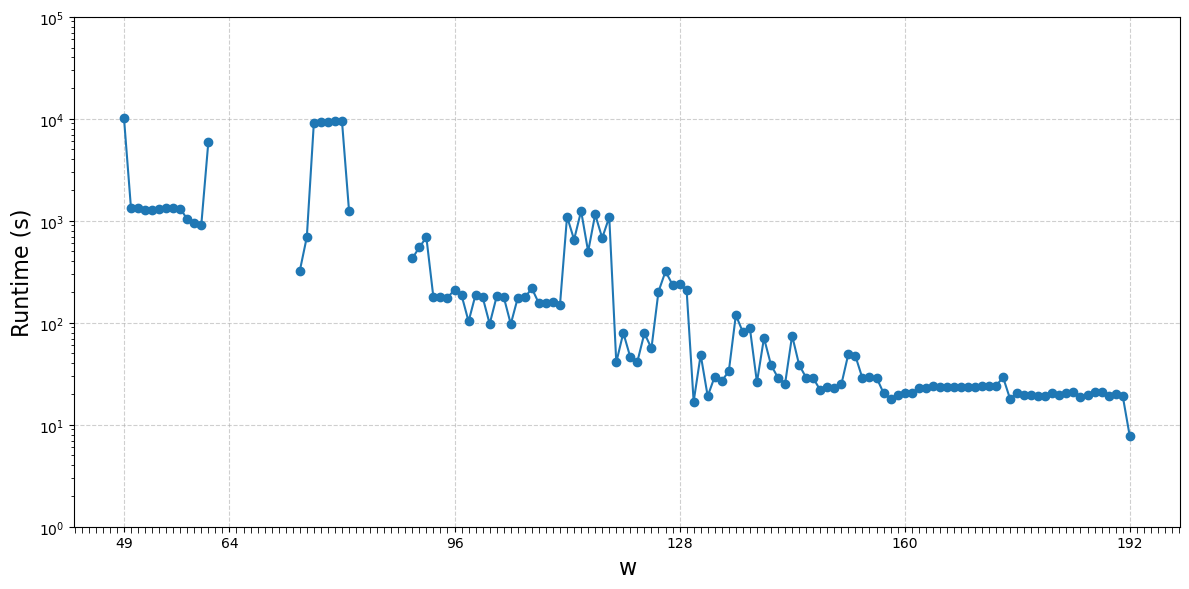

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator

# Load CSV
df = pd.read_csv("runtime_k6.csv")

# Ensure numeric
df["w"] = pd.to_numeric(df["w"], errors="coerce")
df["newst_ts"] = pd.to_numeric(df["newst_ts"], errors="coerce")

# Determine min/max w where we have actual results
valid_w = df.dropna(subset=["newst_ts"])["w"]
w_min = int(valid_w.min())
w_max = int(valid_w.max())

plt.figure(figsize=(12,6))

# Plot
plt.plot(df["w"], df["newst_ts"], marker="o", linestyle="-")

# ---- LOG SCALE Y-AXIS ----
plt.yscale("log")
y_ticks = [10**i for i in range(0, 6)]
plt.yticks(y_ticks, [f"$10^{i}$" for i in range(0, 6)])

# ---- X TICKS (major) ----
xticks_major = [w_min, w_max]
mult32 = np.arange(32, w_max + 1, 32)
mult32 = [m for m in mult32 if w_min < m < w_max]
xticks_major = sorted(set(xticks_major + mult32))
plt.xticks(xticks_major)

# ---- X MINOR TICKS ----
# Every 4 units keeps it readable; change step to 1 for full resolution
minor_locator = MultipleLocator(1)
plt.gca().xaxis.set_minor_locator(minor_locator)

# Minor ticks but no labels
plt.tick_params(axis='x', which='minor', length=4)

# Clean major grid only
plt.grid(True, which="major", linestyle="--", alpha=0.6)

plt.xlabel("w", fontsize=16)
plt.ylabel("Runtime (s)", fontsize=16)

plt.tight_layout()
plt.savefig("runtime_k6.svg", dpi=300)
plt.show()
